# Notebook demonstrating the use of Timeseriesai for generating predictions
https://github.com/timeseriesAI/timeseriesAI

## The below is done using the tutorial data set (one state, one season) and is a very small dataset so the results are only intended for use on how to use this, not necessarily what the ML capability is

### uses env timeseriesai

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tsai.all import *
from joblib import Parallel, delayed
from openavalancheproject.tsai_utilities import *
import zarr
from fastai.callback.tracker import EarlyStoppingCallback


In [3]:
#chck if GPU is available
torch.cuda.device(0)
torch.cuda.is_available()

True

In [4]:
data_root = 'D:/OAPMLData/'

ml_path = data_root + '/4.MLData/'
interpolation = 1
label = 'Day1DangerAboveTreeline'
file_label = 'ca_co_day1above_3h_84d_small'

In [5]:
X = zarr.open(ml_path + 'X_' + file_label + '.zarr', mode='r')

In [6]:
X.shape

(48000, 82, 673)

In [7]:
utils = TSAIUtilities(X, label)
feature_names = pd.read_csv(ml_path + '/FeatureLabels_' + file_label + '.csv')
feature_names = feature_names['0'].sort_values().values

In [8]:
feature_names

array(['ACPCP_surface_sum', 'APCP_surface_sum', 'APTMP_2maboveground_avg',
       'CAPE_180M0mbaboveground_avg', 'CAPE_255M0mbaboveground_avg',
       'CAPE_surface_avg', 'CIN_180M0mbaboveground_avg',
       'CIN_255M0mbaboveground_avg', 'CIN_surface_avg',
       'GUST_surface_avg', 'RH_0D33M1sigmalayer_avg', 'RH_1000mb_avg',
       'RH_2maboveground_avg', 'RH_30M0mbaboveground_avg', 'RH_975mb_avg',
       'SNOD_surface_avg', 'TMP_1000mb_avg', 'TMP_100maboveground_avg',
       'TMP_200mb_avg', 'TMP_2maboveground_avg',
       'TMP_30M0mbaboveground_avg', 'TMP_30mb_avg',
       'TMP_80maboveground_avg', 'TMP_surface_avg',
       'UGRD_0D995sigmalevel_avg', 'UGRD_1000mb_avg', 'UGRD_100mb_avg',
       'UGRD_10mb_avg', 'UGRD_150mb_avg', 'UGRD_200mb_avg',
       'UGRD_20mb_avg', 'UGRD_250mb_avg', 'UGRD_300mb_avg',
       'UGRD_30mb_avg', 'UGRD_350mb_avg', 'UGRD_400mb_avg',
       'UGRD_450mb_avg', 'UGRD_500mb_avg', 'UGRD_50mb_avg',
       'UGRD_550mb_avg', 'UGRD_600mb_avg', 'UGRD_650mb_avg',

In [9]:
num_train_files = 20 
file_list = []
for i in range(num_train_files):
    file_list.append(pd.read_parquet(ml_path + '/y_train_batch_' + str(i) + '_' + file_label + '.parquet'))

    
num_test_files = 4 
for i in range(num_test_files):
    file_list.append(pd.read_parquet(ml_path + '/y_test_batch_' + str(i + num_train_files) + '_' + file_label + '.parquet'))
    
y_df = pd.concat(file_list).reset_index(drop=True)

In [10]:
y_df['Day1DangerAboveTreeline'].value_counts()

Day1DangerAboveTreeline
Considerable    12000
Moderate        12000
High            12000
Low             12000
Name: count, dtype: int64

In [11]:
y, cat_dict = utils.get_y_as_cat(y_df)
cat_dict

{0: 'Low', 1: 'Moderate', 2: 'Considerable', 3: 'High'}

In [12]:
train_test_seperator = len(y_df[y_df['season'] != '20-21'])

In [13]:
splits = (L(range(0,train_test_seperator)).shuffle(), L(range(train_test_seperator,len(y_df))).shuffle())

In [71]:
feature_mins, feature_maxs = utils.calc_min_max(X, 0, train_test_seperator)

on 0
on 10
on 20
on 30
on 40
on 50
on 60
on 70
on 80


In [72]:
#save feature_mins and feature_maxes to disk
np.save(ml_path + 'feature_mins_' + file_label + '.npy', feature_mins)
np.save(ml_path + 'feature_maxs_' + file_label + '.npy', feature_maxs)

In [14]:
#read feature_mins and feature_maxes from disk
feature_mins = np.load(ml_path + 'feature_mins_' + file_label + '.npy')
feature_maxs = np.load(ml_path + 'feature_maxs_' + file_label + '.npy')


In [15]:
splits2, dls = utils.create_dls(X, y, feature_mins=np.array(feature_mins), feature_maxs=np.array(feature_maxs), sample_frac=1.0, splits=splits, batch_size=96)
splits2

((#40000) [25855,5079,19387,17491,3290,431,29980,15594,38048,29158...],
 (#8000) [40329,42293,44802,42024,43290,40374,43875,44352,46499,40634...])

In [16]:
model = TSTPlus(dls.vars, dls.c, seq_len=X.shape[2], d_model=128, n_heads=4, d_k=48, d_v=48, d_ff=128, dropout=.6, n_layers=11, fc_dropout=.8, store_attn=False)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[accuracy, BalancedAccuracy()],  opt_func=partial(Adam, decouple_wd=False),cbs=[CutMix1d(), ShowGraphCallback2(), PredictionDynamics()])

In [17]:
lr = 1e-5

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.623349,1.383898,0.251000,0.251000,08:27
1,1.626163,1.381914,0.252625,0.252625,05:26
2,1.621034,1.379677,0.277375,0.277375,05:25
3,1.615081,1.376583,0.312125,0.312125,05:26
4,1.616805,1.372434,0.327750,0.327750,05:26
5,1.606668,1.367158,0.327000,0.327000,06:47
6,1.590793,1.360001,0.330000,0.330000,05:33
7,1.596511,1.349417,0.347000,0.347000,05:33
8,1.577028,1.335146,0.359250,0.359250,07:07
9,1.563490,1.317390,0.377750,0.377750,05:33


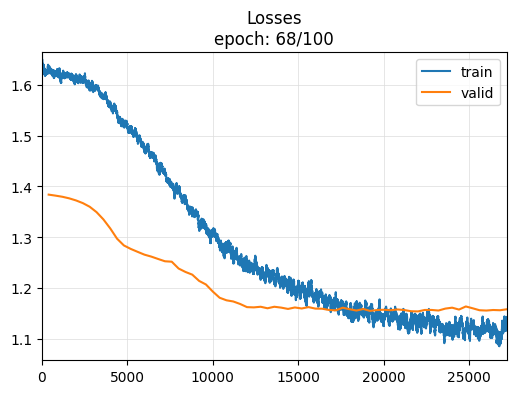

,train_loss,valid_loss,accuracy,balanced_accuracy_score
67,1.139804,1.158003,0.502125,0.502125


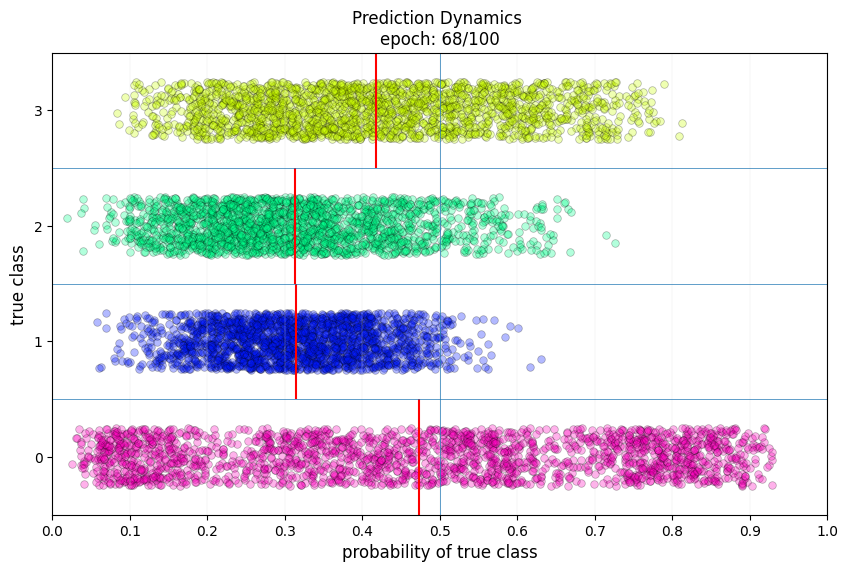

No improvement since epoch 53: early stopping


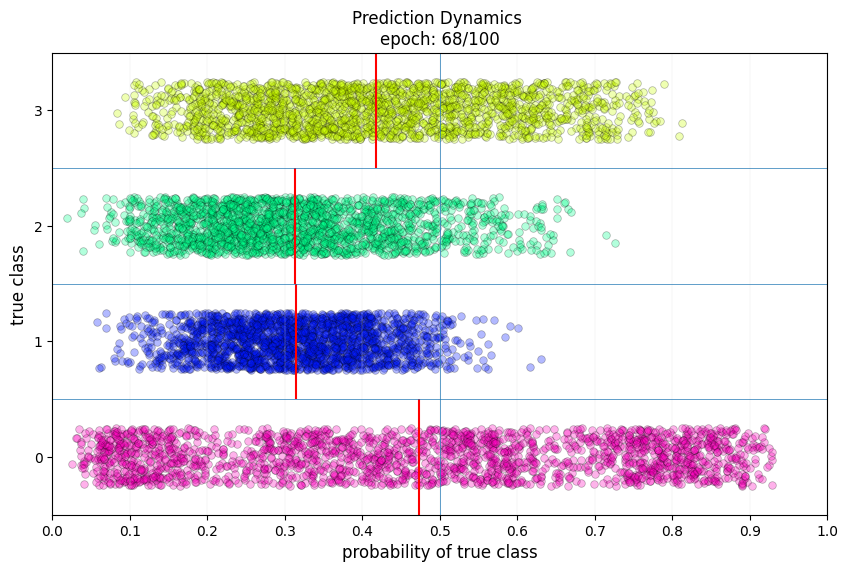

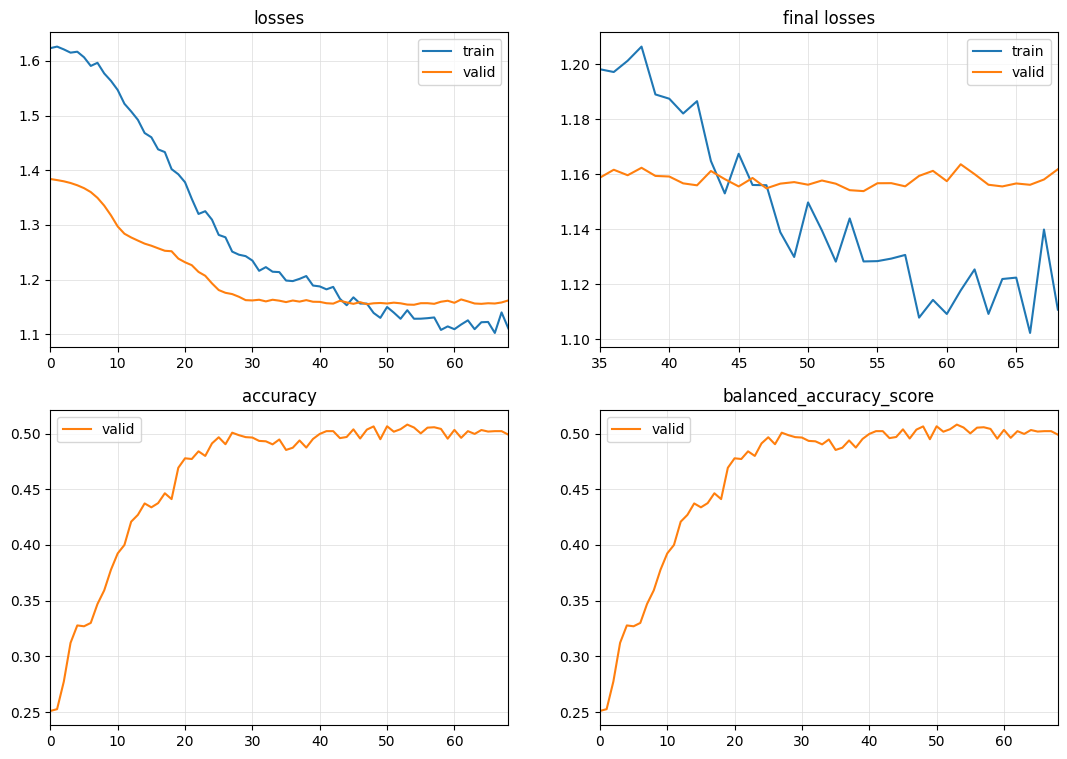

In [19]:
learn.fit_one_cycle(100, lr, cbs=[EarlyStoppingCallback(monitor='accuracy', min_delta=0.001, patience=15)])
#12 layers, 4 heads, fp32, 10.9gb gpu ram, 90% utilization

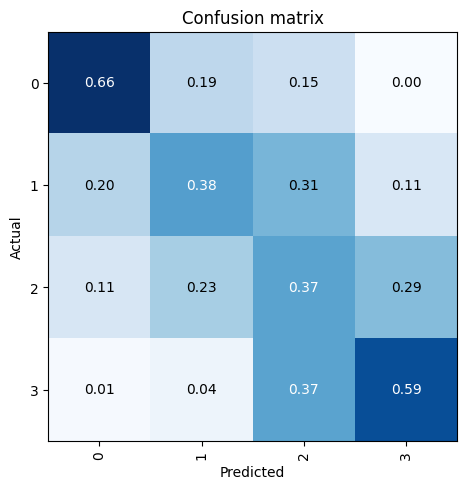

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
conf_matrix = interp.plot_confusion_matrix(normalize=True)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.615022,1.371825,0.351250,0.351250,01:55
1,1.611309,1.365857,0.350500,0.350500,01:55
2,1.600338,1.356042,0.372750,0.372750,01:52
3,1.600130,1.343075,0.374625,0.374625,01:51
4,1.578875,1.325095,0.379750,0.379750,01:51
5,1.548053,1.304538,0.391375,0.391375,01:51
6,1.526993,1.281816,0.401125,0.401125,01:51
7,1.508011,1.259059,0.418625,0.418625,01:51
8,1.465890,1.241968,0.421750,0.421750,01:51
9,1.434683,1.223747,0.434750,0.434750,01:51


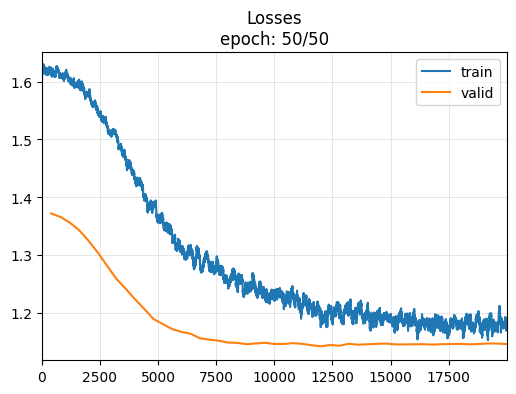

,train_loss,valid_loss,accuracy,balanced_accuracy_score
49,1.180162,1.145924,0.490625,0.490625


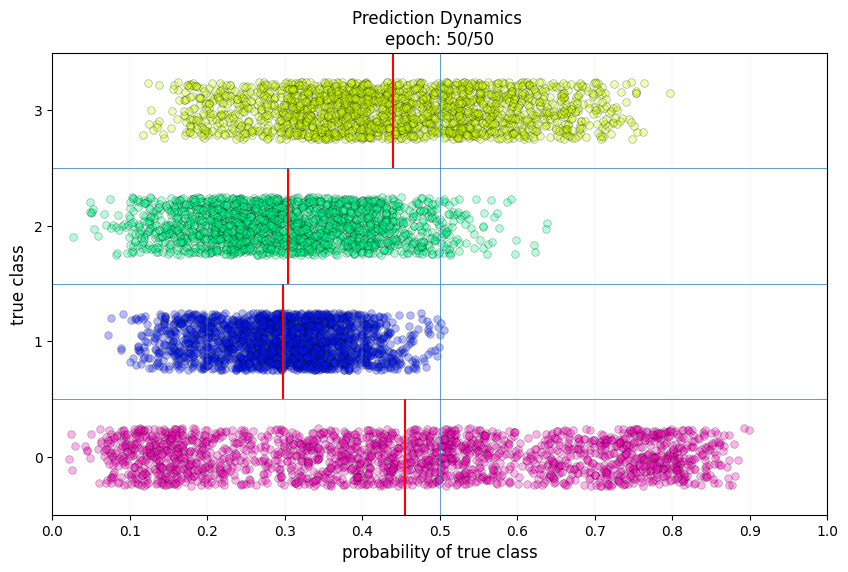

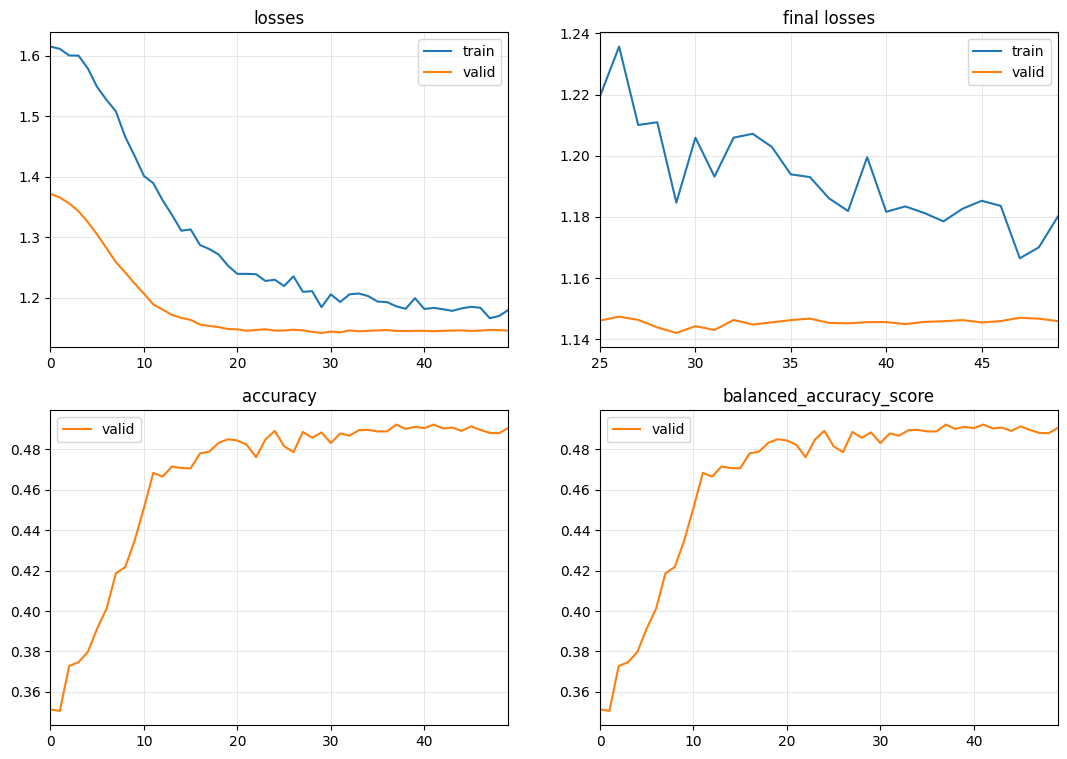

In [29]:
learn.fit_one_cycle(50, lr, cbs=[EarlyStoppingCallback(monitor='accuracy', min_delta=0.001, patience=15)])
#4 layers, 2 heads, fp32, 5gb gpu ram, 50% utilization

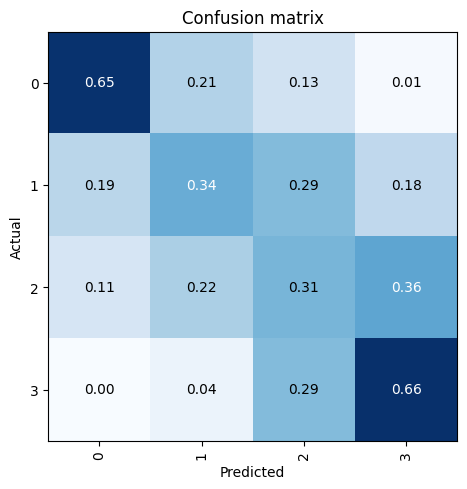

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
conf_matrix = interp.plot_confusion_matrix(normalize=True)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.622980,1.387319,0.284125,0.284125,04:06
1,1.624049,1.379155,0.290125,0.290125,01:03
2,1.596502,1.366477,0.295625,0.295625,01:04
3,1.580133,1.350607,0.321375,0.321375,01:04
4,1.552908,1.331723,0.351375,0.351375,01:09
5,1.516443,1.306988,0.374875,0.374875,03:25
6,1.496144,1.283589,0.385000,0.385000,01:02
7,1.455618,1.259823,0.411750,0.411750,01:03
8,1.417659,1.234247,0.431500,0.431500,01:06
9,1.385778,1.217786,0.436125,0.436125,01:02


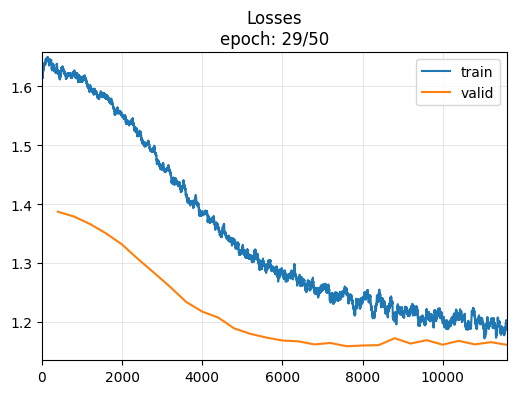

,train_loss,valid_loss,accuracy,balanced_accuracy_score
28,1.196785,1.161358,0.47775,0.47775


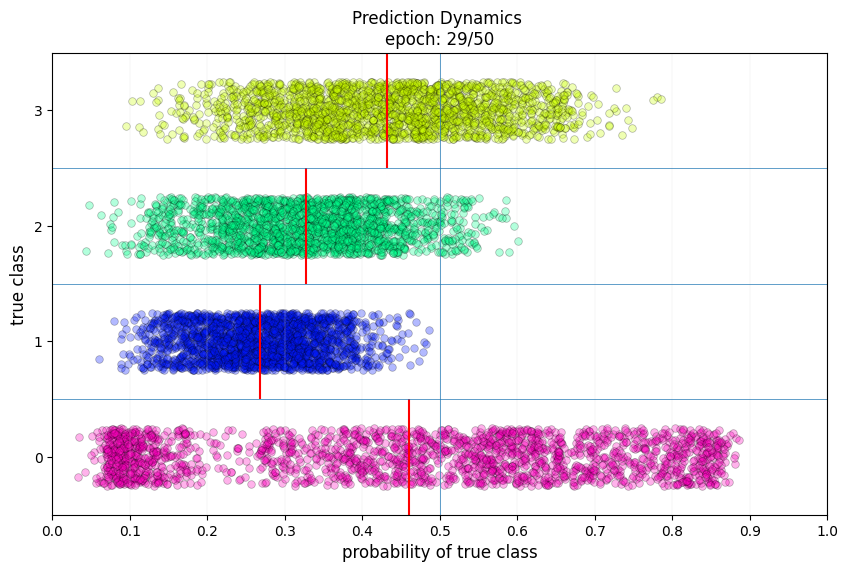

No improvement since epoch 14: early stopping


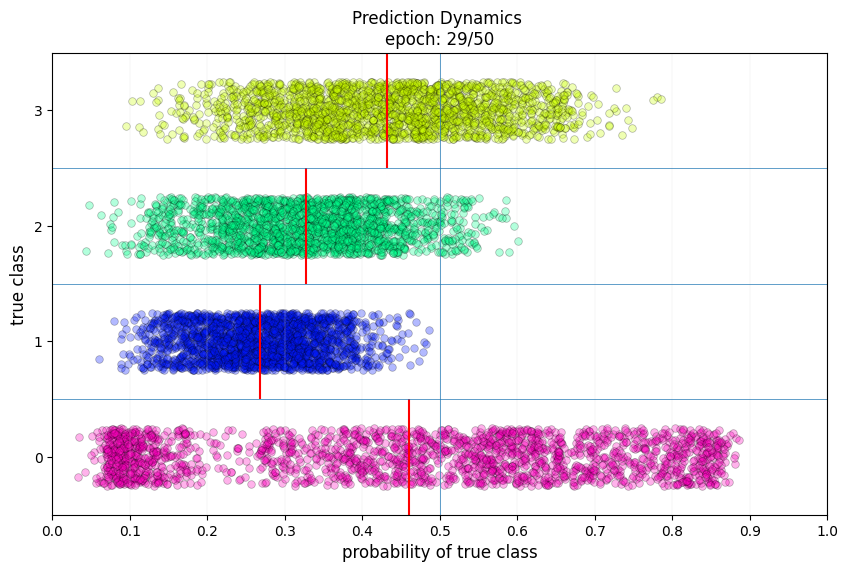

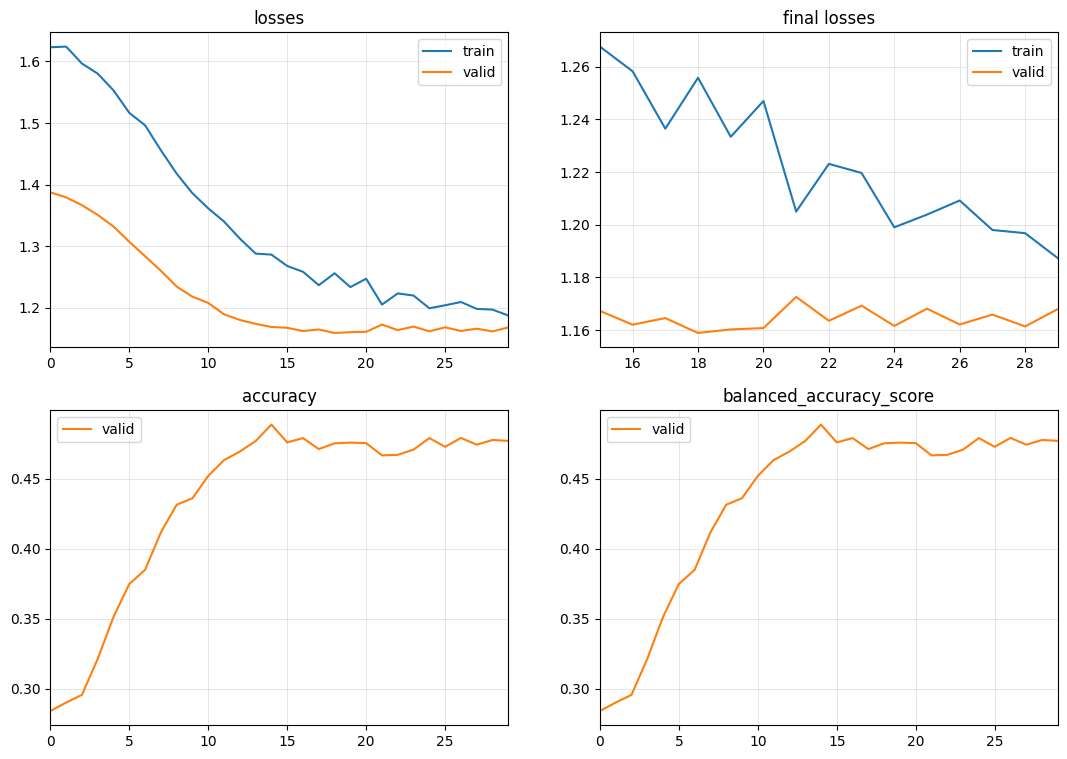

In [18]:
learn.fit_one_cycle(50, lr, cbs=[EarlyStoppingCallback(monitor='accuracy', min_delta=0.001, patience=15)])
#3gb gpu memory total, 6% utilization wiht small spikes to 30%, fp32

### Results


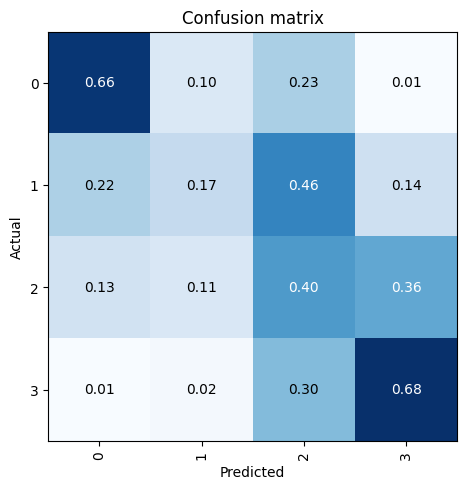

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
conf_matrix = interp.plot_confusion_matrix(normalize=True)

In [23]:
learn = learn.to_fp16()

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,time
0,1.631875,1.387331,0.263000,0.263000,01:05
1,1.616732,1.379048,0.321750,0.321750,01:05
2,1.604959,1.367906,0.362625,0.362625,01:05
3,1.593732,1.352051,0.356625,0.356625,01:07
4,1.562975,1.332504,0.380000,0.380000,01:06
5,1.526275,1.306985,0.393125,0.393125,01:05
6,1.501122,1.279816,0.394500,0.394500,01:06
7,1.453335,1.254000,0.407875,0.407875,01:04
8,1.423655,1.233897,0.437750,0.437750,01:05
9,1.387397,1.217920,0.450625,0.450625,01:06


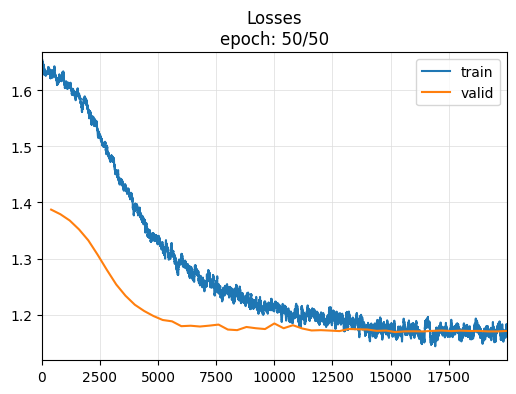

,train_loss,valid_loss,accuracy,balanced_accuracy_score
49,1.180514,1.17126,0.475875,0.475875


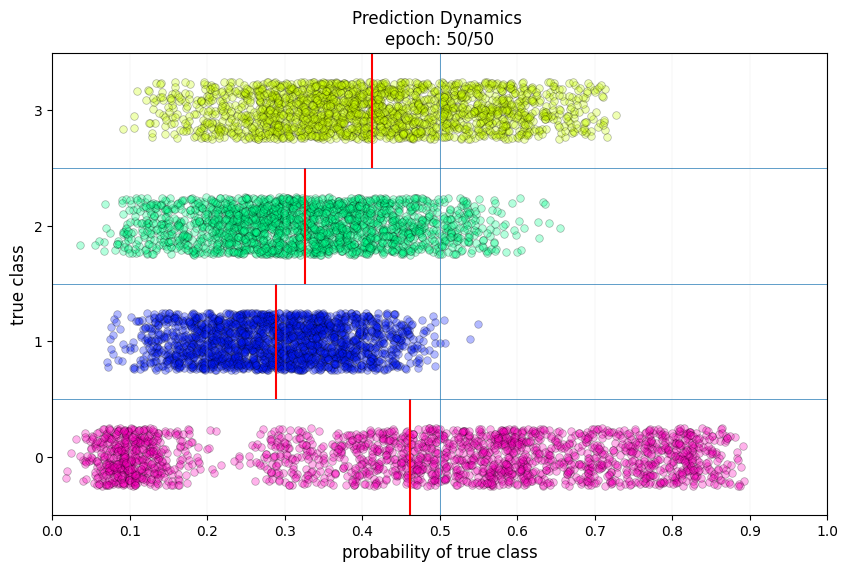

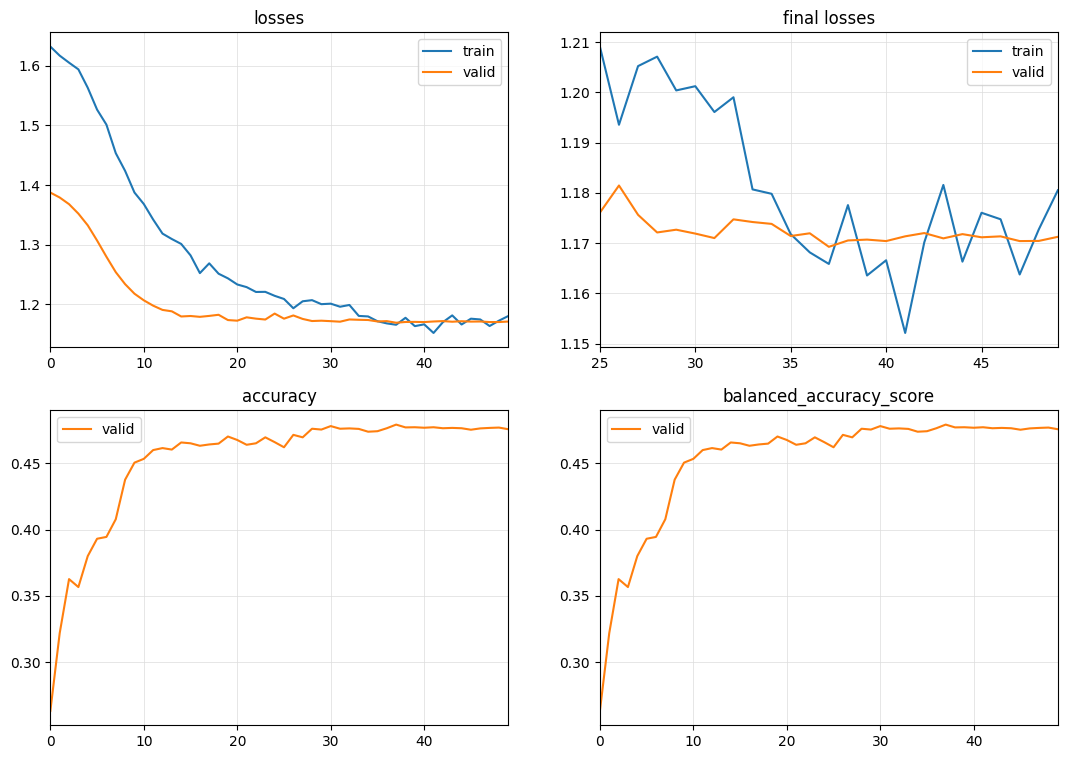

In [24]:
learn.fit_one_cycle(50, lr, cbs=[EarlyStoppingCallback(monitor='accuracy', min_delta=0.001, patience=15)])
#3gb gpu memory total, 20% utilization wiht small spikes, fp16

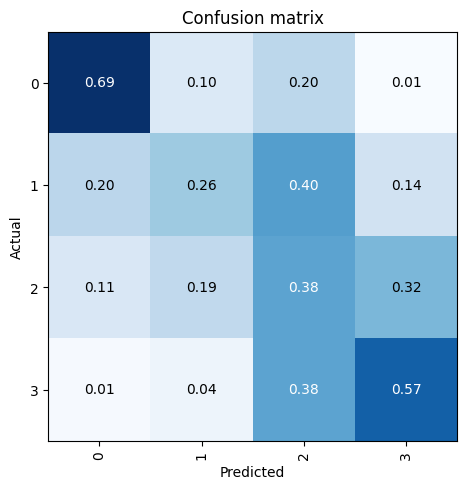

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
conf_matrix = interp.plot_confusion_matrix(normalize=True)

X.shape: (40000, 82, 673)
y.shape: (40000,)
Selected metric: accuracy
Computing feature importance (permutation method)...


  0 feature: BASELINE             accuracy: 0.751700


  0 feature: ACPCP_surface_sum    accuracy: 0.751675


  1 feature: APCP_surface_sum     accuracy: 0.751400


  2 feature: APTMP_2maboveground_avg accuracy: 0.703200


  3 feature: CAPE_180M0mbaboveground_avg accuracy: 0.751775


  4 feature: CAPE_255M0mbaboveground_avg accuracy: 0.751550


  5 feature: CAPE_surface_avg     accuracy: 0.751775


  6 feature: CIN_180M0mbaboveground_avg accuracy: 0.675875


  7 feature: CIN_255M0mbaboveground_avg accuracy: 0.668075


  8 feature: CIN_surface_avg      accuracy: 0.660525


  9 feature: GUST_surface_avg     accuracy: 0.743675


 10 feature: RH_0D44M0D72sigmalayer_avg accuracy: 0.662575


 11 feature: RH_2maboveground_avg accuracy: 0.702800


 12 feature: RH_30M0mbaboveground_avg accuracy: 0.653700


 13 feature: RH_70mb_avg          accuracy: 0.749450


 14 feature: RH_975mb_avg         accuracy: 0.730725


 15 feature: SNOD_surface_avg     accuracy: 0.749200


 16 feature: TMP_100maboveground_avg accuracy: 0.700700


 17 feature: TMP_2maboveground_avg accuracy: 0.683675


 18 feature: TMP_30M0mbaboveground_avg accuracy: 0.645500


 19 feature: TMP_350mb_avg        accuracy: 0.726125


 20 feature: TMP_400mb_avg        accuracy: 0.712850


 21 feature: TMP_800mb_avg        accuracy: 0.669925


 22 feature: TMP_80maboveground_avg accuracy: 0.669725


 23 feature: TMP_surface_avg      accuracy: 0.664125


 24 feature: UGRD_0D995sigmalevel_avg accuracy: 0.731425


 25 feature: UGRD_1000mb_avg      accuracy: 0.743850


 26 feature: UGRD_100mb_avg       accuracy: 0.688375


 27 feature: UGRD_10mb_avg        accuracy: 0.739250


 28 feature: UGRD_150mb_avg       accuracy: 0.700575


 29 feature: UGRD_200mb_avg       accuracy: 0.748500


 30 feature: UGRD_20mb_avg        accuracy: 0.735825


 31 feature: UGRD_250mb_avg       accuracy: 0.751175


 32 feature: UGRD_300mb_avg       accuracy: 0.725950


 33 feature: UGRD_30mb_avg        accuracy: 0.749875


 34 feature: UGRD_350mb_avg       accuracy: 0.744825


 35 feature: UGRD_400mb_avg       accuracy: 0.732550


 36 feature: UGRD_450mb_avg       accuracy: 0.701600


 37 feature: UGRD_500mb_avg       accuracy: 0.719900


 38 feature: UGRD_50mb_avg        accuracy: 0.753000


 39 feature: UGRD_550mb_avg       accuracy: 0.722650


 40 feature: UGRD_600mb_avg       accuracy: 0.742575


 41 feature: UGRD_650mb_avg       accuracy: 0.729575


 42 feature: UGRD_700mb_avg       accuracy: 0.749350


 43 feature: UGRD_70mb_avg        accuracy: 0.744675


 44 feature: UGRD_750mb_avg       accuracy: 0.738800


 45 feature: UGRD_800mb_avg       accuracy: 0.730450


 46 feature: UGRD_850mb_avg       accuracy: 0.749650


 47 feature: UGRD_900mb_avg       accuracy: 0.750600


 48 feature: UGRD_925mb_avg       accuracy: 0.738675


 49 feature: UGRD_950mb_avg       accuracy: 0.751925


 50 feature: UGRD_975mb_avg       accuracy: 0.753300


 51 feature: VGRD_0D995sigmalevel_avg accuracy: 0.756075


 52 feature: VGRD_1000mb_avg      accuracy: 0.748050


 53 feature: VGRD_100mb_avg       accuracy: 0.722450


 54 feature: VGRD_10mb_avg        accuracy: 0.691800


 55 feature: VGRD_150mb_avg       accuracy: 0.736050


 56 feature: VGRD_200mb_avg       accuracy: 0.734575


 57 feature: VGRD_20mb_avg        accuracy: 0.728700


 58 feature: VGRD_250mb_avg       accuracy: 0.730025


 59 feature: VGRD_300mb_avg       accuracy: 0.745900


 60 feature: VGRD_30mb_avg        accuracy: 0.745125


 61 feature: VGRD_350mb_avg       accuracy: 0.742225


 62 feature: VGRD_400mb_avg       accuracy: 0.732150


 63 feature: VGRD_450mb_avg       accuracy: 0.746325


 64 feature: VGRD_500mb_avg       accuracy: 0.729375


 65 feature: VGRD_50mb_avg        accuracy: 0.714725


 66 feature: VGRD_550mb_avg       accuracy: 0.733675


 67 feature: VGRD_600mb_avg       accuracy: 0.732575


 68 feature: VGRD_650mb_avg       accuracy: 0.745325


 69 feature: VGRD_700mb_avg       accuracy: 0.743625


 70 feature: VGRD_70mb_avg        accuracy: 0.733325


 71 feature: VGRD_750mb_avg       accuracy: 0.750575


 72 feature: VGRD_800mb_avg       accuracy: 0.754800


 73 feature: VGRD_850mb_avg       accuracy: 0.755650


 74 feature: VGRD_900mb_avg       accuracy: 0.752525


 75 feature: VGRD_925mb_avg       accuracy: 0.743850


 76 feature: VGRD_950mb_avg       accuracy: 0.748475


 77 feature: VGRD_975mb_avg       accuracy: 0.746075


 78 feature: VVEL_200mb_avg       accuracy: 0.749400


 79 feature: VVEL_450mb_avg       accuracy: 0.749625


 80 feature: WATR_surface_sum     accuracy: 0.751250


 81 feature: WEASD_surface_avg    accuracy: 0.750250



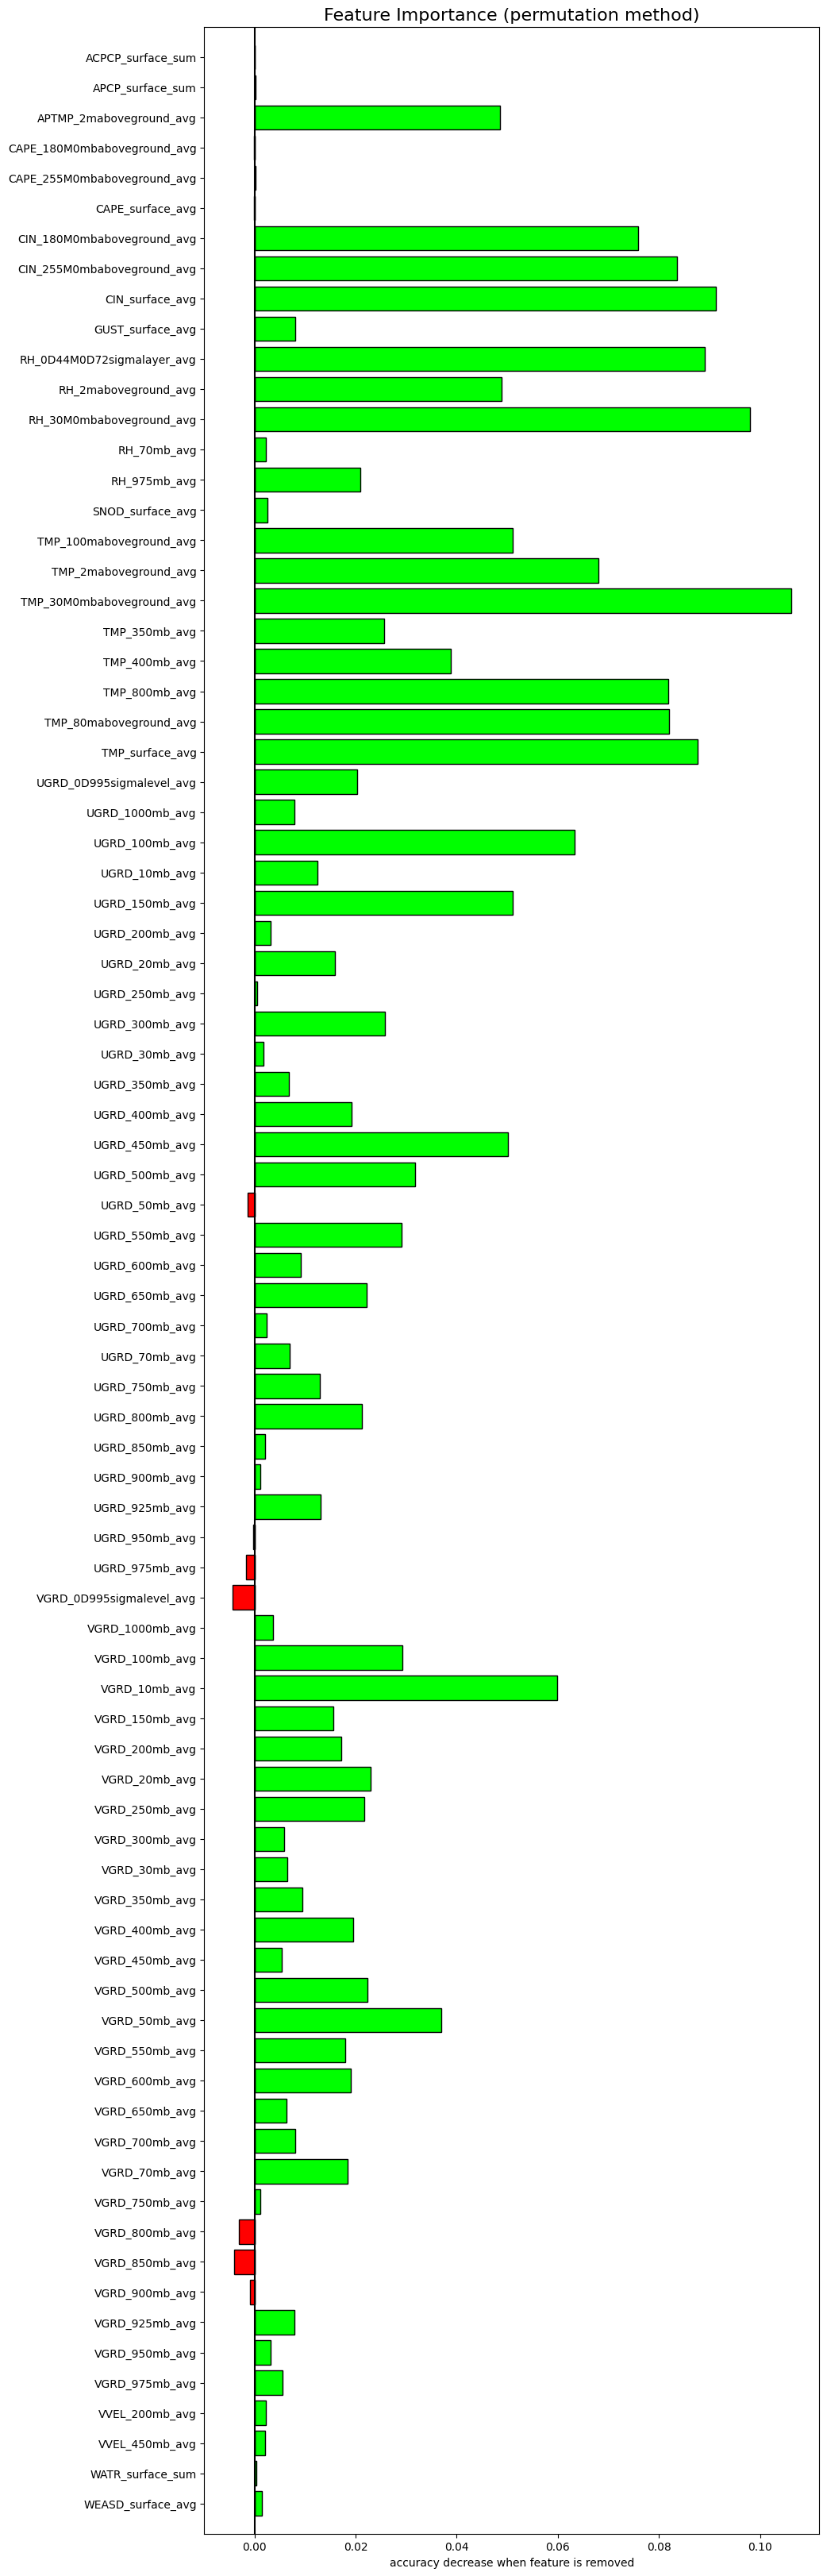

In [34]:
#list feature importances
fi = learn.feature_importance(partial_n=0.1, feature_names=list(feature_names))